In [1]:
import numpy as np # importing numpy for matrix operations 
from scipy import *
from scipy.optimize import minimize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from IPython import display 
import itertools
from IPython.display import display
import random, operator
from random import choices, randint, randrange, random, sample, seed 
from collections import namedtuple
from typing import List, Optional, Callable, Tuple
from functools import partial

In [2]:
#seed(0) #Fix seed 

In [3]:
class IterRegistry(type):
    def __iter__(cls):
        return iter(cls._registry)

In [4]:
class Firm:
    #class attributes intialisation, to be updated with the addition of each instance
    _registry = []
    
    def __init__(self, index, capacity, max_number_of_vessel, design_speed, 
                 min_speed, max_speed, main_engine_power, aux_engine_power,
                 fix_cost, fuel_type):
        '''__init__ a method to describe the poperty that all shipping firm have'''
        self._registry.append(self)
        self.index = index
        self.capacity = capacity # Vessel capacity in TEU per firm, 
        self.max_number_of_vessel = max_number_of_vessel # # of vessels per firms
        self.design_speed = design_speed  #design speed of the vessel in knots
        self.min_speed = min_speed #min vessel speed
        self.max_speed = max_speed #max vessel speed         
        self.main_engine_power =  main_engine_power  # PS_m : main engine power in kW
        self.aux_engine_power =  aux_engine_power  # auxiliary engine power [kW] 
        self.fix_cost = fix_cost #Daily cost of vessel (USD/Day) $25,000
        self.fuel_type = fuel_type
        #self.bau_emission = bau_emission
         
   
    # Firm methods 
    def get_market_share(self , market_instance):
        '''return market share of the firm accoding to it s capacity'''
        self.transport_capacity = np.multiply(self.max_number_of_vessel , self.capacity)
        self.market_share= np.divide(self.transport_capacity, market_instance.market_capacity)
        return self.market_share
        
    def get_firm_param(self, market_instance):
        self.psy = np.multiply (self.market_share , market_instance.market_psy)
        return self.psy
    
    def get_firm_demand(self, market_instance):
        self.firm_demand = np.multiply (self.market_share , market_instance.market_demand)
        return self.firm_demand 
    
    
    def get_min_number_of_vessel(self, market_instance, operational_speed):
        self.time_at_sea = np.true_divide(market_instance.distance,  operational_speed)
        self.voyage_time = self.time_at_sea  + market_instance.port_time 
        self.number_of_trips_to_meet_demand = np.true_divide(self.firm_demand[market_instance.period_index], self.capacity)
        self.max_trips_per_vessel = np.true_divide(market_instance.annual_working_time, self.voyage_time)
        self.min_number_of_vessel_to_meet_demand = np.true_divide(self.number_of_trips_to_meet_demand, self.max_trips_per_vessel)
        return self.min_number_of_vessel_to_meet_demand, self.number_of_trips_to_meet_demand, self.time_at_sea 
    
    def get_number_of_vessel(self):
        self.number_of_vessel = np.ceil(self.min_number_of_vessel_to_meet_demand)
        return self.number_of_vessel
        
        
    def get_ship_energy_efficiency(self, market_instance):
        self.main_fuel_parameter = market_instance.SFOC_main * market_instance.eng_load_main * self.main_engine_power * 10**(-6)
        self.ship_energy = np.multiply(self.main_fuel_parameter, np.power(self.design_speed, -3) )      
        return self.ship_energy
        
    def get_main_fuel_cons(self, market_instance, operational_speed):
        self.main_fuel_cons = market_instance.distance * self.ship_energy * operational_speed**2 *self.number_of_trips_to_meet_demand
        return self.main_fuel_cons
        
    def get_aux_fuel_cons(self, market_instance): 
        self.aux_fuel_parameter = market_instance.SFOC_aux * market_instance.eng_load_aux * self.aux_engine_power * 10**(-6)
        self.aux_fuel_cons =  self.aux_fuel_parameter * self.time_at_sea 
        return self.aux_fuel_cons 
        
    def get_fuel_cost(self, market_instance):
        self.aux_fuel_cost = self.aux_fuel_cons  * market_instance.fuel_data['MGO']['price'] 
        self.main_fuel_cost = self.main_fuel_cons * market_instance.fuel_data[self.fuel_type]['price']  
        self.fuel_cost = self.main_fuel_cost + self.aux_fuel_cost
        return self.fuel_cost
        
    
    def get_total_cost(self):
        self.operating_cost = self.fix_cost * self.number_of_vessel #Fixed Cost
        self.total_cost = self.operating_cost + self.fuel_cost
        return self.total_cost 
    
    def get_revenue(self,market_instance):
        self.revenue = self.firm_demand[market_instance.period_index] * market_instance.freight_rate
        return self.revenue
    
    def get_period_profits(self):
        self.period_profit = self.revenue - self.total_cost 
        return self.period_profit
    
    def get_discounted_period_profit(self,market_instance):
        self.discounted_period_profit = np.multiply( np.power( 1+ market_instance.discount_rate, - market_instance.period_index), self.period_profit) 
        return self.discounted_period_profit
    
    def get_firm_carbon_emission(self, market_instance):
        self.carbon_aux_emision_factor = market_instance.fuel_data['MGO']['carbon_factor']
        self_carbon_aux_emissions = self.carbon_aux_emision_factor * self.aux_fuel_cons 

        self.carbon_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['carbon_factor']
        self_carbon_main_emissions =  self.carbon_main_emision_factor * self.main_fuel_cons

        self_carbon_emissions = self_carbon_main_emissions  + self_carbon_aux_emissions
        return self_carbon_emissions
    
    def get_firm_sulfur_emission(self, market_instance):
        self.sulfur_aux_emision_factor = market_instance.fuel_data['MGO']['sulfur_factor']
        self_sulfur_aux_emissions = self.sulfur_aux_emision_factor * self.aux_fuel_cons 

        self.sulfur_main_emision_factor =  market_instance.fuel_data[self.fuel_type]['sulfur_factor']
        self_sulfur_main_emissions =  self.sulfur_main_emision_factor * self.main_fuel_cons

        self_sulfur_emissions = self_sulfur_main_emissions  + self_sulfur_aux_emissions
        return self_sulfur_emissions

In [5]:
class MarketConfig: 
    #class attributes
    t0 = 2016 #The starting year for evaluation of the pay-offs
    T = 35  # Planning Horizon t = 2016,...,2040 # 100 year scope 
    year = np.arange(2016, 2051)
    distance = 11810 #nautical miles #Notteboom (2006)  
    port_time = 264 #hours ==> 11 days in a year  #Notteboom (2006)
    demand_16_20 = np.array([1303780  for j in range(5)]) #in TEU #placehplder to be calibrated with the chosen route 
    annual_working_time = 6480 #hours per year, assumption   #hours per year, assumption 
    initial_freight_rate = 1800 ## in US$/TEU 
    SFOC_main = 206 #g/kWh, specific daily main engine fuel oil consumption rate
    SFOC_aux = 221 # specific fuel oil consumption of the auxiliary engine [g/kW h], 
    eng_load_main = 0.8 # % 
    eng_load_aux = 0.5 # engine load of the auxiliary engine [\%]


    def __init__(self, number_of_firms, demand_income_elasticity, demand_price_elasticity, 
                 freight_rate, fuel_data, discount_rate ):
        '''__init__ a method to describe the poperty that the shipping market and simulation game has'''
        self.number_of_firms = number_of_firms
        self.demand_income_elasticity = demand_income_elasticity #Constant income elasticity #IMF
        self.demand_price_elasticity =  demand_price_elasticity #Constant own price elasticity#IMF
        self.freight_rate = freight_rate ## in US$/TEU
        self.fuel_data = fuel_data 
        self.discount_rate = discount_rate 
        #self.bau_industry_emission =  bau_industry_emission 
        #self.bau_pollution_stock = bau_pollution_stock
        self.market_capacity = 0 
        self.pollution_stock = 0
        self.industry_damage = 0
        self.global_abatement_benefits = 0
        
    
    def get_market_capacity (self, firm_instance):
        self.market_capacity += firm_instance.max_number_of_vessel * firm_instance.capacity
        return self.market_capacity 
    
    def get_freight_rate_ratio(self): 
        self.beta = np.divide(self.freight_rate, MarketConfig.initial_freight_rate) 
        return self.beta
   
    def get_market_demand(self):
        '''compute market level demand'''
        #---------> 1.Import real GDP growth data & compute GDP ratio : Source IMF@2020 #
        G_df = pd.read_csv('./data/real_growth_rate.csv') #import IMF data
        #-------> 2.Construct GDP projection path 2016-2050 based on projection growth data 
        gdp_growth= G_df.values[:,1:] 
        g =1 +(gdp_growth/100)  
        self.gdp = np.array([100.00 for j in range(MarketConfig.T)])
        for foo in range (1,MarketConfig.T):
            self.gdp[foo] = g[:,foo]* self.gdp[foo-1]
        #print(self.gdp)
        #--------->  "compute GDP ratio based on IMF@2020"
        gdp_ratio = np.array([1.00 for j in range(MarketConfig.T)])
        for moo in range (1,MarketConfig.T):
            sub_g = g[:,0:moo+1]
            #print(sub_g)
            gdp_ratio[moo] = np.prod(sub_g)
        
        #--------->  "compute freight rate ratio"
        self.freight_rate_ratio_multiplied = np.power(self.beta, self.demand_price_elasticity)
        #print(freight_rate_ratio_multiplied)
        
        #---------> "Project Transport Demand (industry demand)"
        loo =np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), self.freight_rate_ratio_multiplied ) #Will need to be updated in case fuel prices are varied over time  
        self.market_demand = np.multiply(loo, MarketConfig.demand_16_20[0])
        #print(Y) # size = 1 dimesion array with size T=35 years
        self.market_psy = np.multiply(np.power(gdp_ratio, self.demand_income_elasticity), MarketConfig.demand_16_20[0] )
        return self.market_demand, self.gdp, self.market_psy
    
    def set_period_index (self, period):
        self.period_index = period
        return self.period_index

        
    def get_industry_emission(self):
        
        pass
    
    def get_pollution_stock(self):
        pass
    
    def get_damage(self):
        pass
    
    def get_global_abatement_benefits(self):
        pass 
    
    def get_firm_abatement_benefits():
        pass

In [27]:
class GAOptimise:
    def __init__():
        pass
    

# 1. Set Up Simulation Parameters:

## * Firm 1:

In [6]:
####################################### 1. Firm & Market specific Parameters ###########################################
                    #===========================>  Firm 1 Attributes <==========================#
index_1 = 1
capacity_1 = 5905
max_number_of_vessel_1= 50
design_speed_1 = 23.3 #design speed of the vessel in knots
min_speed_1 = 8.5
max_speed_1 = 30
main_engine_power_1 = 41186 # main engine power in kW
aux_engine_power_1 = 2433 # auxiliary engine power [kW] 
fix_cost_1 =  6750000  #Daily cost of vessel (USD/Day) $25,000
fuel_type_1 = "HFO"

## * Firm 2:

In [7]:
                    #===========================>  Firm 2 Attributes <==========================#
index_2 = 2
capacity_2 = 6470
max_number_of_vessel_2 = 50
design_speed_2 = 24.7 #design speed of the vessel in knots
min_speed_2 = 8.5
max_speed_2 = 30
main_engine_power_2 = 56273 # main engine power in kW
aux_engine_power_2 =  2433 # auxiliary engine power [kW] 
fix_cost_2 = 6750000 #Daily cost of vessel (USD/Day) $25,000
fuel_type_2 = "HFO"

## * Market :

In [8]:
                    #===========================> Market Attributes <==========================#
firms = 2
year = np.arange(2016, 2051)
income_elasticity = 0.8 #Constant income elasticity #IMF
price_elasticity = -0.7 #Constant own price elasticity#IMF
freight_rate = 1800 ## in US$/TEU
fuel_data = pd.DataFrame(np.array([[422.50, 525.50, 597.00], 
                                [3.114,3.206,3.206],
                                [0.07,0.01,0.002]]),
                         columns=['HFO', 'ULSFO', 'MGO'],
                         index = ['price', 'carbon_factor', 'sulfur_factor'])
discount = 0.02  ##3  to 5 % transport canada ,#to be updated using the Ramsey rule,#pure rate of time preference of 1.5% + growth rate of consumption g * rate of risk conversion , an elasticity value of 2

# 2. Initialize Game and Set up firm and market objects 

In [9]:
""" This cell needs to run once throughout the kernel"""
####################################### 2.Simulation Game Initialisation ###########################################
firm_1 = Firm(index_1, capacity_1, max_number_of_vessel_1, design_speed_1, 
                 min_speed_1, max_speed_1, main_engine_power_1, aux_engine_power_1,
                 fix_cost_1, fuel_type_1) 

firm_2 = Firm(index_2, capacity_2, max_number_of_vessel_2, design_speed_2, 
                 min_speed_2, max_speed_2, main_engine_power_2, aux_engine_power_2,
                 fix_cost_2, fuel_type_2) 

game_config = MarketConfig(firms, income_elasticity, price_elasticity, freight_rate, 
                           fuel_data, discount)

####################################### 3.Get market capacity #################################
for  firm_object in Firm._registry:
    market_capacity_sim = game_config.get_market_capacity(firm_object)

# 3. Market Demand

In [10]:
## Get freight ratio for passethrough
beta_sim = game_config.get_freight_rate_ratio()

# Get market demand  
market_demand_sim, gdp_sim, market_psy_sim = game_config.get_market_demand()
print("market demand", market_demand_sim)

# Get each firm's  market share  
firm_1_market_share_sim = firm_1.get_market_share(game_config)
print("firm 1 market share", firm_1_market_share_sim)

firm_2_market_share_sim = firm_2.get_market_share(game_config)
print("firm 2 market share", firm_2_market_share_sim)

market demand [1303780.         1378613.27053661 1417081.19385409 1448735.913652
 1397511.98183639 1455352.28446974 1504050.11466377 1549602.07735933
 1594072.22320876 1638552.17226732 1684273.26074193 1731270.12057536
 1779578.35005746 1829234.54078948 1880276.30540081 1932742.30603904
 1986672.28365504 2042107.08810522 2099088.70909364 2157660.30797763
 2217866.2504608  2279752.14019835 2343364.85334008 2408752.57403719
 2475964.83093995 2545052.53471369 2616068.01660168 2689065.06806397
 2764098.98152235 2841226.59224218 2920506.32138292 3001998.22024985
 3085764.01578064 3171867.15730103 3260372.86458528]
firm 1 market share 0.4771717171717172
firm 2 market share 0.5228282828282829


### Graphing Market Demand:

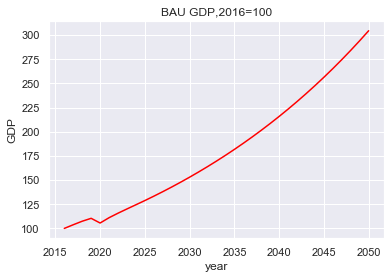

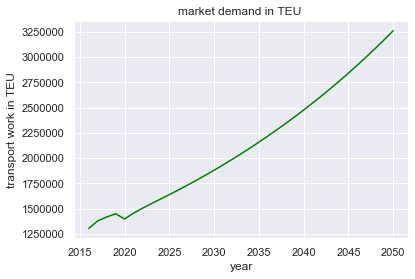

In [11]:
#======> Plotting BAU GDP,2016=100
sns.set()
ax=sns.lineplot(x=year ,y =gdp_sim, color = 'red')
ax.set(xlabel='year', ylabel='GDP')
plt.title("BAU GDP,2016=100" )
plt.show()

#======> Plotting Market Demand Projections in BAU senario: Y
ax=sns.lineplot(x=year ,y = market_demand_sim, color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("market demand in TEU " )
plt.show()

#======> Plotting Marketshare per firm



# 4. Compute BAU emission path for Firm 1 :

# Firm 1:

In [12]:
 # 7.Get firm passthrough parameter
firm_1_psy_sim = firm_1.get_firm_param(game_config)

# 7.Get firm level demand  
firm_1_demand_sim = firm_1.get_firm_demand(game_config)
print("firm 1 demand", firm_1_demand_sim)
    
# 9.Get ship energy efficiency  
firm_1_ship_energy_sim = firm_1.get_ship_energy_efficiency(game_config)
print("firm 1 ship energy", firm_1_ship_energy_sim)

firm 1 demand [ 622126.94141414  657835.26161767  676191.06664311  691295.80364566
  666853.19214092  694452.94867021  717690.17592643  739426.28418641
  760646.18004426  781870.75371625  803687.56401464  826113.13632303
  849164.45713853  872858.98693833  897214.6734054   922249.96502307
  947983.82504913  974435.7458797  1001625.76381397 1029574.47423094
 1058303.04718958 1087833.24346435 1118187.43102814 1149388.60199512
 1181460.39003639 1214427.08828156 1248313.66771983 1283145.79611457
 1318949.85744561 1355752.97189415 1393583.01638514 1432468.64570306
 1472439.31419674 1513525.29808991 1555757.71841423]
firm 1 ship energy 0.0005365856566237424


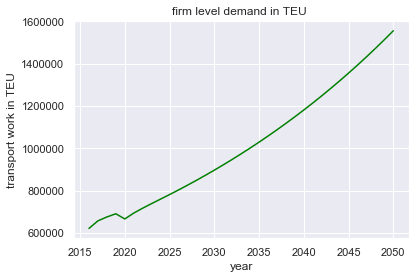

In [13]:
#======> Plotting The firm's 
ax=sns.lineplot(x=year ,y = firm_1_demand_sim , color = 'green')
ax.set(xlabel='year', ylabel='transport work in TEU')
plt.title("firm level demand in TEU " )
plt.show()

# Set Period Index

In [14]:
# 7.Set period index  
period_index_sim = game_config.set_period_index(1)

# Solve GA for period index

# Genetic Algorithm :

In [15]:
#====> Iinitialisation
Chromo = List[float] 
Population = List[Chromo]  

#====> Iinitialisation of function object
PopulateFunc = Callable[[], Population]
FitnessFunc = Callable[[Chromo], Tuple[float, int, float, float]] #int to refelct max # of vessel
SelectionFunc = Callable[[Population, FitnessFunc], Tuple[Chromo, Chromo]]  #takes a population and a fitness fn to select 2 solutions to be the parents of our next generaation solution
CrossoverFunc = Callable[[Chromo, Chromo], Tuple[Chromo, Chromo]] #takes 2 genomes and returns 2 new genomes 
MutationFunc = Callable[[Chromo], Chromo] #takes 1 genome and sometimes returns a modified one


In [16]:
#Steps of the GA
#========> Define chromosome as speed level
#Using uniformly random elements is a good choice 
#becaise we can cover the entire solution space quite well.

def generate_chromo(lower_bound:float, 
                    upper_bound:float) -> Chromo:
    return np.random.uniform(lower_bound, upper_bound)

#========> Generate population as a list of size =50 of random speed level
def generate_population(size: int, 
                        chromo_lower_bound: float , 
                        chromo_upper_bound: float) -> Population: 
    return [generate_chromo(chromo_lower_bound, chromo_upper_bound) for _ in range(size)]


In [17]:
#========> Define fitness function based on the simulation game
def fitness (chromo: Chromo, 
             firm: Firm, 
             sim_game: MarketConfig, 
             max_number_of_vessel: int) -> Tuple[float, int, float, float]:
    
    min_number_vessels_sim , trips_to_meet_demand_sim, time_at_sea_sim  = firm.get_min_number_of_vessel(sim_game, chromo)
    #print("min number of vessel is", min_number_vessels_sim )
    #print("number of trips to meet demand", trips_to_meet_demand_sim )
    #print("Time spent at sea", time_at_sea_sim )

    number_vessels_sim  = firm.get_number_of_vessel()
    #print("number of vessel is", number_vessels_sim)
    
    #Insert Model Constraints Here, Update Vessel speed constraint 
    if number_vessels_sim > max_number_of_vessel:
        return 0
    else:
        main_fuel_con_sim = firm.get_main_fuel_cons(sim_game, chromo)
        #print('main fuel consumption is ', main_fuel_con_sim)
        
        aux_fuel_con_sim = firm.get_aux_fuel_cons(sim_game)
        #print('aux fuel consumption is ', aux_fuel_con_sim)

        fuel_cost_sim = firm.get_fuel_cost(sim_game)
        #print( "fuel cost",fuel_cost_sim)
        
        total_cost_sim = firm.get_total_cost()
        #print("total cost",total_cost_sim)
        
        revenues_sim = firm.get_revenue(sim_game)
        #print("revenues", revenues_sim)
        
        period_profits_sim = firm.get_period_profits()
        #print ("period profits ", period_profits_sim)
        
        discounted_period_profits_sim = firm.get_discounted_period_profit(sim_game)
        #print("discounted period profits ", discounted_period_profits_sim)
        
        #We will see about the carbon and sulfir emississons 
        carbon_emissions_sim = firm.get_firm_carbon_emission(sim_game)
        #print("carbon emissions",carbon_emissions_sim)
        
        sulfur_emissions_sim = firm.get_firm_sulfur_emission(sim_game)
        #print( "sulfur emissions", sulfur_emissions_sim)
        
        return  discounted_period_profits_sim, number_vessels_sim, carbon_emissions_sim, sulfur_emissions_sim

In [18]:
#========> #Survival of the fittest  and parent selection 
def selection_pair(population: Population, fitness_func: FitnessFunc) -> Population:
    '''select a pair of chromo which will be the parent of 2 new chromo for the next generation, Solution with higher fitness should be more likely to be chosen for reproduction'''
    return choices(
        population = population,
        weights=[fitness_func(chromo)[0] for chromo in population],
        k=2
        ) 

####
# def selection(generation, method='Fittest Half'):
#     generation['Normalized Fitness'] = sorted([generation['Fitness'][x]/sum(generation['Fitness']) for x in range(len(generation['Fitness']))], reverse = True)
#     generation['Cumulative Sum'] = np.array( generation['Normalized Fitness']).cumsum()
    
#     if method == 'Roulette Wheel':
#         selected = []
#         for x in range(len(generation['Individuals'])//2):
#             selected.append(roulette(generation ['Cumulative Sum'], rnd()))
#             while len(set(selected)) != len(selected):
#                 selected[x] = (roulette(generation['Cumulative Sum'], rnd()))
#         selected = {'Individuals': [generation['Individuals'][int(selected[x])] for x in range(len(generation['Individuals'])//2)],
#                     'Fitness': [generation['Fitness'][int(selected[x])] for x in range(len(generation['Individuals'])//2)]}
        
#         elif method == 'Fittest Half':
#         selected_individuals = [generation['Individuals'][-x-1] for x in range(int(len(generation['Individuals'])//2))]
#         selected_fitnesses = [generation['Fitness'][-x-1] for x in range(int(len(generation['Individuals'])//2))]
#         selected = {'Individuals': selected_individuals,
#                     'Fitness': selected_fitnesses}
#     elif method == 'Random':
#         selected_individuals = [generation['Individuals'] [randint(1,len(generation['Fitness']))] for x in range(int(len(generation['Individuals'])//2))]
#         selected_fitnesses = [generation['Fitness'][-x-1] for x in range(int(len(generation['Individuals'])//2))]
#         selected = {'Individuals': selected_individuals,
#                     'Fitness': selected_fitnesses}
#     return selected


#==> might update to tounment selection 

In [19]:
#========> #crossover function  
def blend_crossover (a: Chromo, b: Chromo) -> Tuple[Chromo, Chromo]:
    lower = min(a,b) -  0.5 * (max(a,b) - min (a,b))
    upper = max(a,b) +  0.5 * (max(a,b) - min (a,b))                    
    return np.random.uniform (lower, upper, 2) 

#==================================================================#
#Given parents  a : chromo1 and b:chromo2 :
#randomly select a child between
# min(a,b) - alpha *[max(a,b) - min (a,b)] &  max(a,b) + alpha *[max(a,b) - min (a,b)]
# best practice alpha = 0.5  
# def linear_crossover (a: Chromo, b: Chromo) -> Tuple[Chromo, Chromo]:
#     c =  0.5 * a + 0.5 * b
#     d = 1.5 * a - 0.5 * b
#     e = -0.5 * a - 1.5 * b
#     children = [a,b,c,d,e]
#     return  max(fitness_func(crossed) for crossed in children)

# #Given parents  a : chromo1 and b:chromo2 :
# #create 3 solutions: 
# # 0.5 a + 0.5 b
# # 1.5 a - 0.5 b
# #-0.5 a - 1.5 b
# # ====> Children = the 2 best solutions among the 5 

In [20]:
#========> #mutation function: randomly perturb the values
def mutation(chromo: Chromo, mutate_params: tuple, num: int = 1, probability: float = 0.5) -> Chromo: 
    for _ in range(num):
        # if random retuns a value lower or equal to probablity, the chromo falls whitihinn the mutation probabality 
        if random() <= probability:
            chromo += np.random.normal(0, mutate_params['rate'], mutate_params['dim'])
    
        if chromo < mutate_params['lower_bound']:
            chromo = mutate_params['lower_bound']
            
        elif chromo > mutate_params['upper_bound']:
            chromo = mutate_params['upper_bound']
        return chromo
#Example: add Gaussian noise to each offspring. Maybe a mean of zero and a standard deviation of 0.25 is fine. 
   
 #Normal distribution : A gaussian with mean 0 and and a chosen standard deviation   x_new = xi +N(0, sigma) 
#1. Random mutation 
#2. Non-Uniform Mutation
#3.Normally distributed mutation 
# loc= 0.0
# scale= rate = 0.25  (standard deviation)
# size= dim =1 #output shape
 
     
# Uniform variation: x_new = xi + (ri - 0.5) delta_i
             
#     def mutate(self, mutate_params):
#         self.value += np.random.normal(0, mutate_params['rate'], mutate_params['dim'])
#         for i in range(len(self.value)):
#             if self.value[i] < mutate_params['lower_bound']:
#                 self.value[i] = mutate_params['lower_bound']
#             elif self.value[i] > mutate_params['upper_bound']:
#                 self.value[i] = mutate_params['upper_bound']
            

    



# Main GA call function 
generations = 100 populations = 100 (50 * solution)
The algorithm we will follow is simple. 
Given a `fitness function`, $f(\cdot)$ we are trying to maximize, and for a certain number of generations limit, do the following:
1. Initialize the population with random vessel speed in $V_{min}, V_{max}$; `parents`

2. Compute the discounted profits in the selected period for each chromosome in the population, then use this as the fitness function we are trying to minimize

3. Sample the `parents` with sampling weights based on fitness (i.e. those with greater fitness have greater likelihood of being resampled); these will be used to create `children` for the next generation

4. With some `crossover rate` select pairs of `parents` and randomly combine characteristics

5. With some `mutation rate` mutate the `parents`

6. The population from steps 4-5 become the `children` from the previous generation. Repeate steps 1-7.




1. Create the population of individuals 
Generate an initial population of individuals randomly.

2. Evaluate the fitness of each individual in the population.
The higher the fitness, the longer the individual's properties (DNA) stay  in the population, either by the individual itself or its offspring

3. Repeat as often :
a) Select individuals with a good fitness score for reproduction.
b) Let them produce offsprings.
c) Mutate these offsprings.
d) Evaluate the fitness of each individual in the population.
f) Let the individuals with a bad fitness score die.


4. Pick the individual with the highest fitness as the solution

we maintain a constant population size of 50

## Termination Criteria 
until the solutions don’t get better anymore.

Maximum similar fitness number: Due to elitism best individual in a generation moves on to the next generation without mutating. This individual can be the best individual in the next generation as well. We can limit the number for the same individual to be the best individual as this can be sing that the genetic algorithm got stuck in a local minima. The function for checking if the maximum fitness value have changed can be written as;



In [21]:
def fitness_similarity_chech(max_fitness, number_of_similarity):
    result = False
    similarity = 0
    for n in range(len(max_fitness)-1):
        if np.round(max_fitness[n], 3 ) == np.round(max_fitness[n+1],3):
            similarity += 1
        else:
            similarity = 0
    if similarity == number_of_similarity-1:
        result = True
    return result

In [22]:
#-------------------------------- MAIN GA Function ----------------------------------------- #
def run_evolution(populate_func: PopulateFunc,
                  fitness_func: FitnessFunc,
                  mutation_func: MutationFunc, 
                  generation_limit: int = 100,
                  number_of_similarity: int = 3,
                  selection_func: SelectionFunc = selection_pair,
                  crossover_func: CrossoverFunc = blend_crossover 
                 ) -> Tuple[Population, pd.DataFrame ]:
    """The evolutionnary main loop""" 

    #1. Genrate the 1st generation: Initial generation/population
    population = populate_func()
    
    
    #2. Implement a termination criteria 

    
    
    #2 Simulate until you reach generation limit,
    i = 0
    results = pd.DataFrame(columns=['Generation', 'Vessel Speed', 'Firm Discounted profit', 
                                'Number of vessels', 'Carbon Emissions', 'Sulfur Emissions'])
    similarity = 0   
    
    for i in range(generation_limit):
        #Step 1 : Sort solutions in the population of generation i based on fitness to select the best 2 solutions 
        population = sorted(population, key=lambda chromo: fitness_func(chromo)[0], reverse=True) 
        
        #Step 2 
        results = results.append({'Generation': i,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
        
        
        if fitness_similarity_chech(results['Firm Discounted profit'], number_of_similarity) == True:
            break

                   
    
#         print(results)
#         print (i)
#         print("Best vessel speed in the", i, "th generation is" ,population[0] ) 
#         print("Best fitness in the", i, "th generation is", fitness_func(population[0]))
         
                    
        #Step 2: Implement elitism and pick the top 2 chromo(speed) in the population based on fitness for the next gernation 
        next_generation = population[0:2]  
        #print("next generation", next_generation)
        
        
        
        #Step 3: j in range 24 
        for j in range(int(len(population) / 2) - 1):
            #Step 1: Selection 
            parents = selection_func(population, fitness_func)
            #print("parent are", parents) 
            
            #Step 2: Crossover
            offspring_a, offspring_b = crossover_func(parents[0], parents[1])

            #Step 3: mutation 
            offspring_a = mutation_func(offspring_a)
            offspring_b = mutation_func(offspring_b)
            #print("offspring a ", offspring_a) 
            #print("offspring b", offspring_b) 
            
            #Step 4: Next generation 
            next_generation += [offspring_a, offspring_b]
            
        #print("next generation",i, "is", next_generation)       
        population = next_generation #update current population with our next generation and start into the next round of the algo by sorting the population and checking if we reached our fitness limit 
    
    #Sort the population one last time in case we run out of generation  
    population = sorted(
            population, 
            key=lambda chromo: fitness_func(chromo)[0], reverse=True)
    
    

    results = results.append({'Generation': i+1,
                          'Vessel Speed': population[0],
                          'Firm Discounted profit': fitness_func(population[0])[0],
                          'Number of vessels': fitness_func(population[0])[1] , 
                          'Carbon Emissions': fitness_func(population[0])[2] , 
                          'Sulfur Emissions': fitness_func(population[0])[3] }, ignore_index=True) 
    print(results)

    return population, results

# Runing the GA 

In [23]:
#-------------------------------- MAIN  ----------------------------------------- #
#Update size population to 50 solutions,ie chromo per population
population, results = run_evolution( populate_func = partial(generate_population,
                                                    size=50,                                                    
                                                    chromo_lower_bound = min_speed_1 ,
                                                    chromo_upper_bound = max_speed_1),
                                        fitness_func = partial(fitness,
                                                               firm = firm_1,
                                                               sim_game = game_config, 
                                                               max_number_of_vessel = max_number_of_vessel_1),
                                        generation_limit = 100,
                                        number_of_similarity = 40,
                                        mutation_func = partial (mutation,
                                                                 mutate_params = {'lower_bound': min_speed_1, 'upper_bound': max_speed_1, 'rate': 0.25, 'dim': 1}
                                                                ) 
    
                                       )

    Generation          Vessel Speed Firm Discounted profit Number of vessels  \
0          0.0               12.3934             9.7685e+08                21   
1          1.0               12.3934             9.7685e+08                21   
2          2.0  [13.241599765146312]    [977118890.3937405]            [20.0]   
3          3.0  [13.241599765146312]    [977118890.3937405]            [20.0]   
4          4.0               13.2249            9.77248e+08                20   
..         ...                   ...                    ...               ...   
75        75.0  [13.134631859664445]    [977942795.0160569]            [20.0]   
76        76.0  [13.134631859664445]    [977942795.0160569]            [20.0]   
77        77.0  [13.134631859664445]    [977942795.0160569]            [20.0]   
78        78.0  [13.134631859664445]    [977942795.0160569]            [20.0]   
79        79.0  [13.134631859664445]    [977942795.0160569]            [20.0]   

        Carbon Emissions   

# Evaluating The GA performance

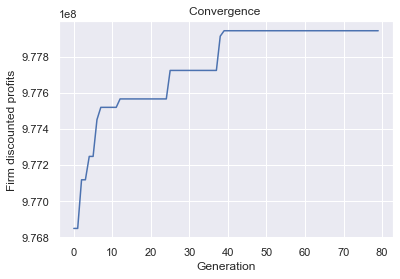

In [24]:
plt.plot(results['Generation'].values, results['Firm Discounted profit'].values)
plt.title("Convergence " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Generation')
plt.show()

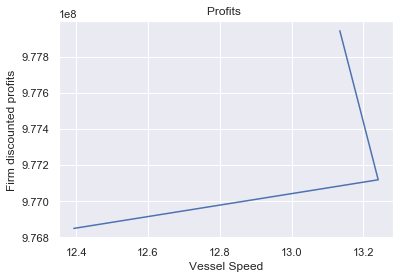

In [25]:
plt.plot(results['Vessel Speed'].values, results['Firm Discounted profit'].values)
plt.title("Profits " )
plt.ylabel('Firm discounted profits')
plt.xlabel('Vessel Speed')
plt.show()

# Optimum Solution: 

In [26]:
solution_period =  

SyntaxError: invalid syntax (<ipython-input-26-9b4dab12350f>, line 1)

# Run the GA for all periods for each firm

# Compute BAU emission path for Firm 2 :

# Firm 2

In [ ]:
# 7.Get firm passthrough parameter
firm_2_psy_sim = firm_2.get_firm_param(game_config)

# 7.Get firm level demand  
firm_2_demand_sim = firm_2.get_firm_demand(game_config)
print("firm 2 demand", firm_2_demand_sim)


# 9.Get ship energy efficiency  
firm_2_ship_energy_sim = firm_2.get_ship_energy_efficiency(game_config)
print("firm 2 ship energy", firm_2_ship_energy_sim)